In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!cp /content/drive/MyDrive/CNN_stories/cnn_stories_tokenized.zip /content/cnn_stories_tokenized.zip
!unzip -q /content/cnn_stories_tokenized.zip -d /content/cnn_stories

In [ ]:
#!cp -r /content/drive/MyDrive/cnn_stories/

In [12]:
!pip install tqdm seaborn pandas matplotlib

In [17]:
import os
import glob
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re

# Configuration
sns.set_style("whitegrid")

# ==========================================
# PARTIE 1 : PARSING DES FICHIERS .story
# ==========================================

def parse_story_file(file_path):
    """
    Parse un fichier .story et extrait l'article et les highlights

    Args:
        file_path: chemin vers le fichier .story

    Returns:
        dict avec 'article' (texte complet) et 'highlights' (liste de résumés)
    """
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        lines = [line.strip() for line in f.readlines()] # strip all lines initially

    article_lines = []
    highlights = []
    in_highlights_section = False

    for line in lines:
        if line == '@highlight':
            in_highlights_section = True
            continue # Skip the highlight marker itself

        if line: # Only process non-empty lines
            if in_highlights_section:
                highlights.append(line)
            else:
                article_lines.append(line)

    return {
        'article': ' '.join(article_lines),
        'article_sentences': article_lines,
        'highlights': highlights,
        'num_sentences': len(article_lines),
        'num_highlights': len(highlights)
    }


def load_dataset(data_dir, max_files=None, sample_mode='first'):
    """
    Charge l'ensemble des fichiers .story du répertoire

    Args:
        data_dir: répertoire contenant les fichiers .story
        max_files: nombre maximum de fichiers à charger (None = tous)
        sample_mode: 'first', 'random', ou 'stratified'

    Returns:
        DataFrame avec les données parsées
    """
    story_files = glob.glob(os.path.join(data_dir, '*.story'))

    print(f"📁 {len(story_files)} fichiers .story trouvés")

    # Échantillonnage si demandé
    if max_files and max_files < len(story_files):
        if sample_mode == 'random':
            np.random.seed(42)
            story_files = np.random.choice(story_files, max_files, replace=False).tolist()
        else:  # 'first'
            story_files = story_files[:max_files]
        print(f"📊 Échantillon de {max_files} fichiers sélectionné (mode: {sample_mode})")

    data = []
    for file_path in tqdm(story_files, desc="Parsing fichiers"):
        parsed = parse_story_file(file_path)
        parsed['file_id'] = Path(file_path).stem
        data.append(parsed)

    df = pd.DataFrame(data)
    return df


# ==========================================
# PARTIE 2 : ANALYSE EXPLORATOIRE
# ==========================================

def analyze_dataset(df):
    """
    Analyse exploratoire du dataset
    """
    print("\n" + "="*60)
    print("📊 STATISTIQUES DESCRIPTIVES")
    print("="*60)

    # Calcul des longueurs en mots
    df['article_length'] = df['article'].apply(lambda x: len(x.split()))
    df['highlights_length'] = df['highlights'].apply(lambda h: sum(len(s.split()) for s in h))
    df['avg_sentence_length'] = df['article_length'] / df['num_sentences']

    stats = df[['num_sentences', 'num_highlights', 'article_length',
                'highlights_length', 'avg_sentence_length']].describe()

    print(f"\n{stats.round(2)}\n")

    print(f"💡 Observations clés:")
    print(f"  • Articles: {df['article_length'].mean():.0f} mots en moyenne (médiane: {df['article_length'].median():.0f})")
    print(f"  • Résumés: {df['highlights_length'].mean():.0f} mots en moyenne (médiane: {df['highlights_length'].median():.0f})")
    print(f"  • Taux de compression: {(df['highlights_length'].mean() / df['article_length'].mean() * 100):.1f}%")
    print(f"  • Nombre de highlights par article: {df['num_highlights'].mean():.1f}")

    return df


def plot_distributions(df):
    """
    Visualisation des distributions
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Distribution longueur articles
    axes[0, 0].hist(df['article_length'], bins=50, edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(df['article_length'].mean(), color='red', linestyle='--', label=f'Moyenne: {df["article_length"].mean():.0f}')
    axes[0, 0].axvline(df['article_length'].median(), color='green', linestyle='--', label=f'Médiane: {df["article_length"].median():.0f}')
    axes[0, 0].set_xlabel('Nombre de mots')
    axes[0, 0].set_ylabel('Fréquence')
    axes[0, 0].set_title('Distribution de la longueur des articles')
    axes[0, 0].legend()

    # Distribution longueur résumés
    axes[0, 1].hist(df['highlights_length'], bins=50, edgecolor='black', alpha=0.7, color='orange')
    axes[0, 1].axvline(df['highlights_length'].mean(), color='red', linestyle='--', label=f'Moyenne: {df["highlights_length"].mean():.0f}')
    axes[0, 1].axvline(df['highlights_length'].median(), color='green', linestyle='--', label=f'Médiane: {df["highlights_length"].median():.0f}')
    axes[0, 1].set_xlabel('Nombre de mots')
    axes[0, 1].set_ylabel('Fréquence')
    axes[0, 1].set_title('Distribution de la longueur des résumés')
    axes[0, 1].legend()

    # Nombre de phrases par article
    axes[1, 0].hist(df['num_sentences'], bins=50, edgecolor='black', alpha=0.7, color='green')
    axes[1, 0].axvline(df['num_sentences'].mean(), color='red', linestyle='--', label=f'Moyenne: {df["num_sentences"].mean():.0f}')
    axes[1, 0].set_xlabel('Nombre de phrases')
    axes[1, 0].set_ylabel('Fréquence')
    axes[1, 0].set_title('Distribution du nombre de phrases par article')
    axes[1, 0].legend()

    # Relation article vs résumé
    axes[1, 1].scatter(df['article_length'], df['highlights_length'], alpha=0.3, s=10)
    axes[1, 1].set_xlabel('Longueur article (mots)')
    axes[1, 1].set_ylabel('Longueur résumé (mots)')
    axes[1, 1].set_title('Relation longueur article vs résumé')

    # Ligne de régression simple
    z = np.polyfit(df['article_length'], df['highlights_length'], 1)
    p = np.poly1d(z)
    axes[1, 1].plot(df['article_length'], p(df['article_length']), "r--", alpha=0.8, label=f'y={z[0]:.3f}x+{z[1]:.1f}')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.savefig('data_exploration.png', dpi=300, bbox_inches='tight')
    print("\n📊 Graphiques sauvegardés dans 'data_exploration.png'")
    plt.show()


def show_examples(df, n=3):
    """
    Affiche quelques exemples du dataset
    """
    print("\n" + "="*60)
    print("📝 EXEMPLES D'ARTICLES ET RÉSUMÉS")
    print("="*60)

    sample = df.sample(n=min(n, len(df)), random_state=42)

    for idx, row in sample.iterrows():
        print(f"\n{'─'*60}")
        print(f"Exemple {idx+1}")
        print(f"{'─'*60}")
        print(f"\n📰 ARTICLE ({row['article_length']} mots, {row['num_sentences']} phrases):")
        print(f"{row['article'][:500]}..." if len(row['article']) > 500 else row['article'])
        print(f"\n✨ RÉSUMÉS ({row['num_highlights']} highlights, {row['highlights_length']} mots):")
        for i, highlight in enumerate(row['highlights'], 1):
            print(f"  {i}. {highlight}")


# ==========================================
# PARTIE 3 : PRÉPARATION TRAIN/VAL/TEST
# ==========================================

def split_dataset(df, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, random_state=42):
    """
    Sépare le dataset en train/validation/test
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Les ratios doivent sommer à 1"

    # Mélange
    df_shuffled = df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    n = len(df_shuffled)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))

    train_df = df_shuffled[:train_end]
    val_df = df_shuffled[train_end:val_end]
    test_df = df_shuffled[val_end:]

    print("\n" + "="*60)
    print("✂️  SÉPARATION TRAIN/VAL/TEST")
    print("="*60)
    print(f"  • Train: {len(train_df)} exemples ({len(train_df)/n*100:.1f}%)")
    print(f"  • Validation: {len(val_df)} exemples ({len(val_df)/n*100:.1f}%)")
    print(f"  • Test: {len(test_df)} exemples ({len(test_df)/n*100:.1f}%)")

    return train_df, val_df, test_df


🚀 Démarrage de la préparation des données CNN/Daily Mail
📁 92579 fichiers .story trouvés
📊 Échantillon de 15000 fichiers sélectionné (mode: first)


Parsing fichiers: 100%|██████████| 15000/15000 [00:04<00:00, 3308.36it/s]



📊 STATISTIQUES DESCRIPTIVES

       num_sentences  num_highlights  article_length  highlights_length  \
count       15000.00        15000.00        15000.00           15000.00   
mean           21.30            3.56          759.50              45.74   
std            11.73            0.56          401.47              11.02   
min             0.00            1.00            0.00              11.00   
25%            13.00            3.00          442.00              38.00   
50%            19.00            4.00          697.00              46.00   
75%            27.00            4.00         1015.00              54.00   
max           213.00            5.00         2171.00              94.00   

       avg_sentence_length  
count             14979.00  
mean                 36.35  
std                  10.55  
min                   4.30  
25%                  29.95  
50%                  34.44  
75%                  40.57  
max                 451.00  

💡 Observations clés:
  • Article

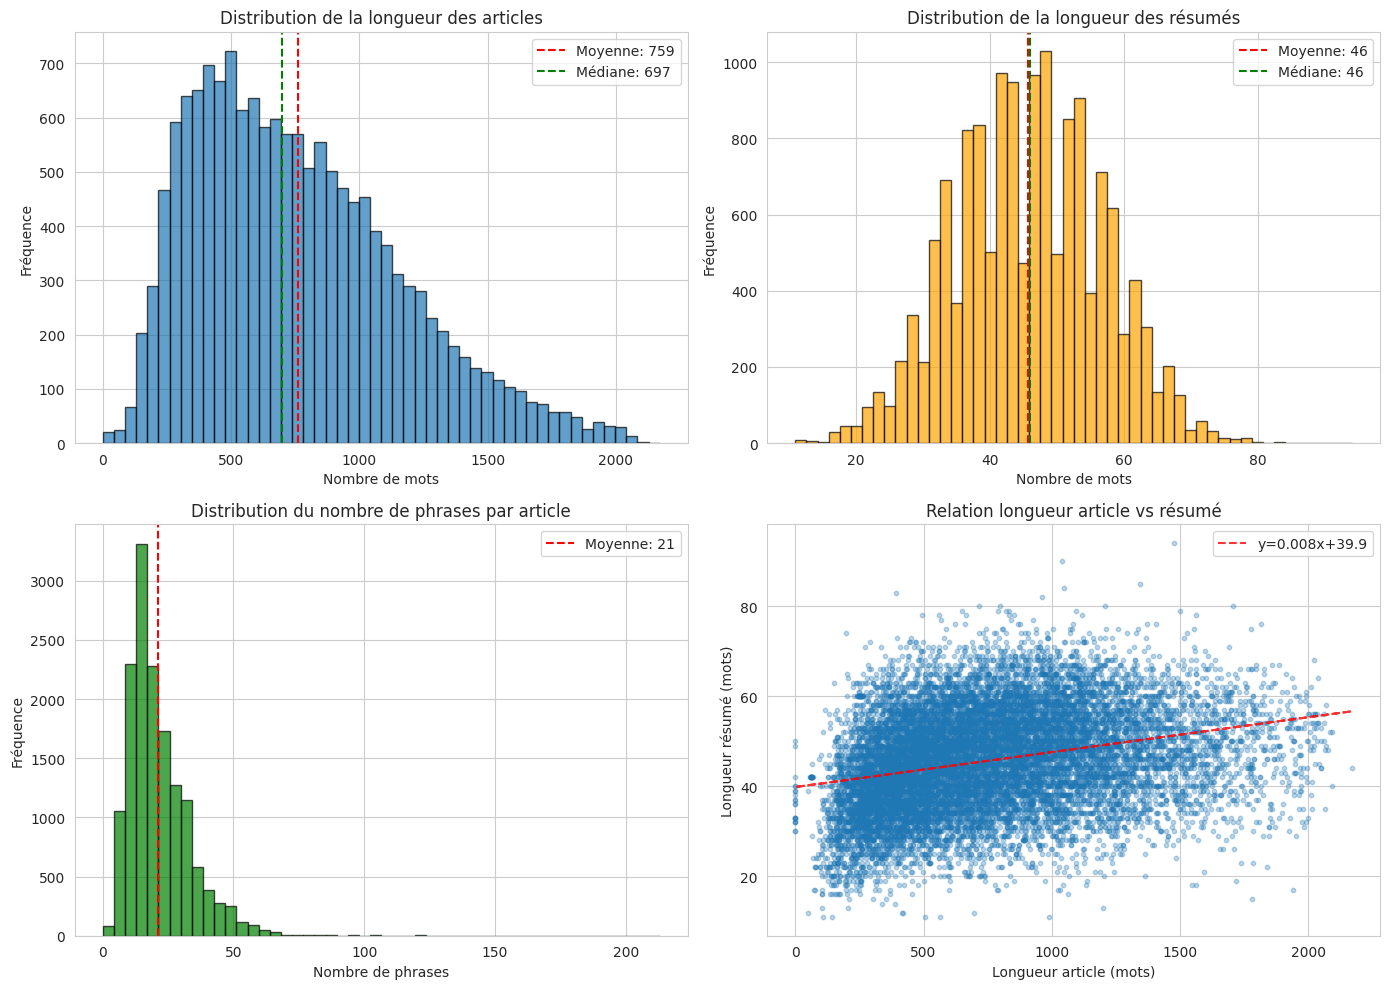


📝 EXEMPLES D'ARTICLES ET RÉSUMÉS

────────────────────────────────────────────────────────────
Exemple 11500
────────────────────────────────────────────────────────────

📰 ARTICLE (971 mots, 17 phrases):
-LRB- CNN -RRB- -- Mexico City , home to 20 million people , represents the paradox of the modern Mexico , the side-by-side juxtaposition -- in everything from politics to architecture -- of old and new . Turn a corner , and you 'll see a church that is 300 years old . Turn another , and you can get Wi-Fi in a Starbucks . The Distrito Federal , also known as Mexico City , serves as a constant reminder that Mexicans are about maintaining tradition , except when they 're sidestepping it . They 're...

✨ RÉSUMÉS (4 highlights, 59 mots):
  1. Ruben Navarrette : In Mexico , the old and new are juxtaposed in everything
  2. Navarrette : Issues break down into urban vs. rural , dark-skinned vs. light-skinned
  3. Light-skinned Mexicans have the advantages , he says , but nobody talks about 

In [21]:

# ==========================================
# PARTIE 4 : UTILISATION
# ==========================================

if __name__ == "__main__":
    """
    Script principal d'utilisation

    INSTRUCTIONS:
    1. Monter votre Google Drive ou uploader vos données
    2. Modifier DATA_DIR vers votre répertoire de fichiers .story
    3. Ajuster MAX_FILES pour un échantillon (None = tous les fichiers)
    """

    # CONFIG

    DATA_DIR = "/content/cnn_stories/cnn_stories_tokenized"  # Répertoire contenant les .story
    MAX_FILES = 15000  # Mettre None pour charger tout le dataset (92K fichiers)

    print("🚀 Démarrage de la préparation des données CNN/Daily Mail")
    print("="*60)

    # Chargement
    df = load_dataset(DATA_DIR, max_files=MAX_FILES, sample_mode='first')

    # Analyse
    df = analyze_dataset(df)

    # Visualisations
    plot_distributions(df)

    # Exemples
    show_examples(df, n=3)

    # Split train/val/test
    train_df, val_df, test_df = split_dataset(df, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)


    print("\n" + "="*60)
    print("✨ Préparation des données terminée avec succès!")
    print("="*60)


In [22]:


# Créer un dossier pour le projet
import os
project_dir = '/content/drive/MyDrive/RCP217_Projet_Summarization'
os.makedirs(project_dir, exist_ok=True)

# Sauvegarder les fichiers sur Drive
print("\n💾 Sauvegarde sur Google Drive...")
train_df.to_pickle(f'{project_dir}/train_data.pkl')
val_df.to_pickle(f'{project_dir}/val_data.pkl')
test_df.to_pickle(f'{project_dir}/test_data.pkl')

print(f"✅ Fichiers sauvegardés dans : {project_dir}")
print("  • train_data.pkl")
print("  • val_data.pkl")
print("  • test_data.pkl")


💾 Sauvegarde sur Google Drive...
✅ Fichiers sauvegardés dans : /content/drive/MyDrive/RCP217_Projet_Summarization
  • train_data.pkl
  • val_data.pkl
  • test_data.pkl
